## DASC 550 Project3: Electricity Demand Prediction
### [[Can]] [[Mergen]]
### 0078490

#### Submission Deadline: August 29, 2022 11:59 PM

In this project, you are going to build an end-to-end machine learning solution using a recurrent neural network for electricity demand prediction problem. You should use `tensorflow` library to build your neural network.

The data set is provided at  https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption, which contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). The measurements are given at the minute resolution. You should first resample data to obtain hourly measurements using `pandas.DataFrame.resample` function. The target variable is at `global_active_power` column. You will predict the electricity demand of the next hour using past measurements.

While building your regression model, you should decide what to do with missing values and how to split the data set into learning, validation and test sets. You should report the predictive performances on learning, validation and test sets.

You should also report the metrics you choose to measure the performance of the solution you developed and the reasoning behind your choices.

### Outline of the data analysis process:
#### 1. Data Initial Cleanup   

* The process of making sure data is accurate, consistent, and useable is known as data cleaning. Data can be made clean by locating faults or corruptions, fixing them, erasing them, or manually processing the data as necessary to stop the same errors from happening,          
* Clean the data as there may be many missing data like "" and NaN.      

#### 2. Exploratory Data Analysis (EDA)

* Data analysis utilizing visual methods is called Exploratory Data Analysis (EDA). With the use of statistical summaries and graphical representations, it is used to identify trends, patterns, or to verify assumptions.

#### 3. Data Preprocessing

* Clean if there are outliers and biased data column,
* Convert categorical data into numerical representation so that we can use them to train machine learning models,   
* Transform data into suitable forms.

#### 4. Model Selection and Evaluation

* Selection of LSTM Model
* Conclusion of the results with predictions

### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
#For extracting zip file and convert it to folder with the name "household_power_consumption"

#import zipfile as zf
#files = zf.ZipFile("household_power_consumption.zip", 'r')
#files.extractall('household_power_consumption')
#files.close()

### 1- Data Initial Cleanup

In [3]:
electricity_df = pd.read_csv("household_power_consumption/household_power_consumption.txt",
                             sep=';',parse_dates={"datetime" : ["Date", "Time"]}, 
                             infer_datetime_format=True,
                             low_memory=False)

In [4]:
electricity_df = electricity_df.set_index("datetime")

I read the csv dataset by combining the date and time columns as date_time and used infer_datetime_format as True to increase the parsing speed by 5-10x. While doing that, it gave me a warning that columns have mixed types so I set low_memory as False for not getting any issue by column formats. After that, I set the date_time created column as my index since I will use it for my further analysis.

In [5]:
electricity_df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


The columns are seen as object columns, however there aren't any nan values except the "Sub_metering_3" column, the NaN values can be implemented differently in the dataset.

In [7]:
electricity_df["Global_active_power"].value_counts()

?        25979
0.218     9565
0.216     9363
0.322     9350
0.324     9304
         ...  
7.094        1
7.930        1
8.274        1
8.246        1
8.600        1
Name: Global_active_power, Length: 4187, dtype: int64

It seems that some column NaN values are implemented as "?", this create bias in the dataset.First, I will turn them into NaN and then turn them into numerical columns.

In [8]:
electricity_df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [9]:
electricity_df = electricity_df.replace("?",np.NaN)
electricity_df = electricity_df.replace("nan",np.NaN)

In [10]:
elec_cols = electricity_df.columns
elec_cols

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [11]:
electricity_df[elec_cols] = electricity_df[elec_cols].astype(float)

In [12]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [13]:
electricity_df[electricity_df["Global_active_power"] > 9]["Global_active_power"].value_counts()

9.106    2
9.590    2
9.694    2
9.242    2
9.726    2
        ..
9.224    1
9.686    1
9.012    1
9.666    1
9.648    1
Name: Global_active_power, Length: 70, dtype: int64

In [14]:
electricity_df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [15]:
electricity_df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.00000,1.09162,1.05729,0.07600,0.30800,0.60200,1.52800,11.12200
Global_reactive_power,2049280.00000,0.12371,0.11272,0.00000,0.04800,0.10000,0.19400,1.39000
Voltage,2049280.00000,240.83986,3.23999,223.20000,238.99000,241.01000,242.89000,254.15000
Global_intensity,2049280.00000,4.62776,4.44440,0.20000,1.40000,2.60000,6.40000,48.40000
Sub_metering_1,2049280.00000,1.12192,6.15303,0.00000,0.00000,0.00000,0.00000,88.00000
Sub_metering_2,2049280.00000,1.29852,5.82203,0.00000,0.00000,0.00000,1.00000,80.00000
Sub_metering_3,2049280.00000,6.45845,8.43715,0.00000,0.00000,1.00000,17.00000,31.00000


In [16]:
for i in elec_cols:
    print(str(i)+" min and max values:")
    print(electricity_df[i].min(),electricity_df[i].max())

Global_active_power min and max values:
0.076 11.122
Global_reactive_power min and max values:
0.0 1.39
Voltage min and max values:
223.2 254.15
Global_intensity min and max values:
0.2 48.4
Sub_metering_1 min and max values:
0.0 88.0
Sub_metering_2 min and max values:
0.0 80.0
Sub_metering_3 min and max values:
0.0 31.0


In this graph also shows that there are missing values which are described before, in order to fill that values I have to do my EDA to see the skewness of the columns. If the data is not skewed, I will use mean, if it is skewed I will use median to replace NaN values.

### 2- Exploratory Data Analysis (EDA)

In [17]:
electricity_df[36:96]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 18:00:00,2.790,0.180,237.52,11.8,0.0,0.0,18.0
2006-12-16 18:01:00,2.624,0.144,238.20,11.0,0.0,0.0,17.0
2006-12-16 18:02:00,2.772,0.118,238.28,11.6,0.0,0.0,17.0
2006-12-16 18:03:00,3.740,0.108,236.93,16.4,0.0,16.0,18.0
2006-12-16 18:04:00,4.928,0.202,235.01,21.0,0.0,37.0,16.0
2006-12-16 18:05:00,6.052,0.192,232.93,26.2,0.0,37.0,17.0
2006-12-16 18:06:00,6.752,0.186,232.12,29.0,0.0,36.0,17.0
2006-12-16 18:07:00,6.474,0.144,231.85,27.8,0.0,37.0,16.0
2006-12-16 18:08:00,6.308,0.116,232.25,27.0,0.0,36.0,17.0


As it can be seen from here there are no missing values in minutes and every minute has its own global active power.

(2075259, 7) (1938786, 7)


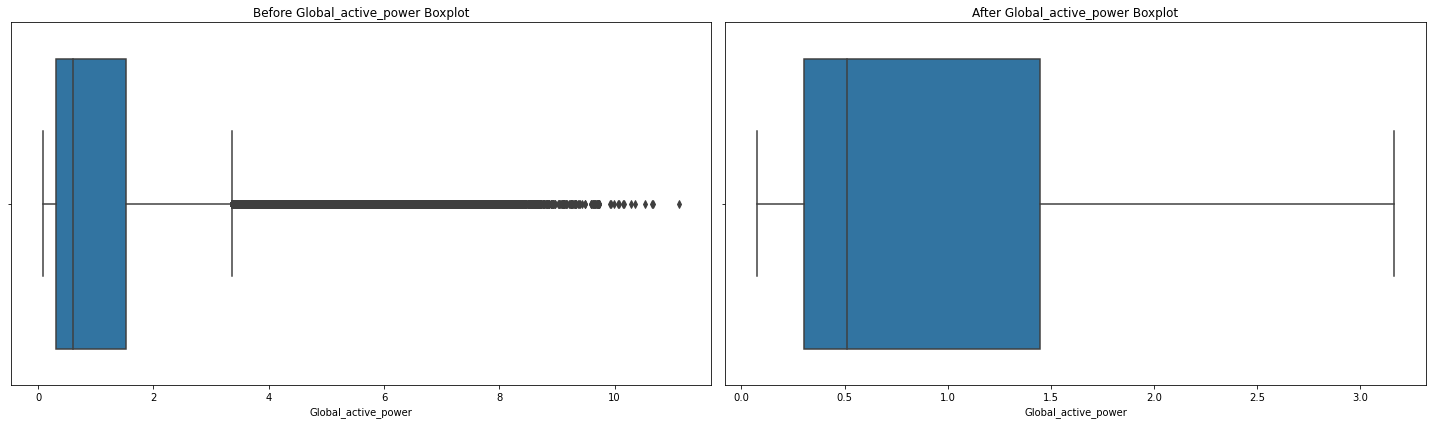

In [18]:
#Removing Outliers on Boxplot
electricity_df_out = electricity_df[electricity_df["Global_active_power"] < 3.164]
print(electricity_df.shape,electricity_df_out.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(x = "Global_active_power", data=electricity_df, ax=axs[0])
axs[0].set_title("Before Global_active_power Boxplot")
sns.boxplot(x = "Global_active_power", data=electricity_df_out, ax=axs[1])
axs[1].set_title("After Global_active_power Boxplot")
fig.tight_layout()
plt.show()

In [19]:
print("The difference between electricity outliers: " + str(len(electricity_df)-len(electricity_df_out)))

The difference between electricity outliers: 136473


Since there are 2.075.259 values in the dataset, removing 136.473 outliers wouldn't have a huge effect on the dataset, but if the dataset was small, another way should have been taken for the outliers instead of removing them for better results. 

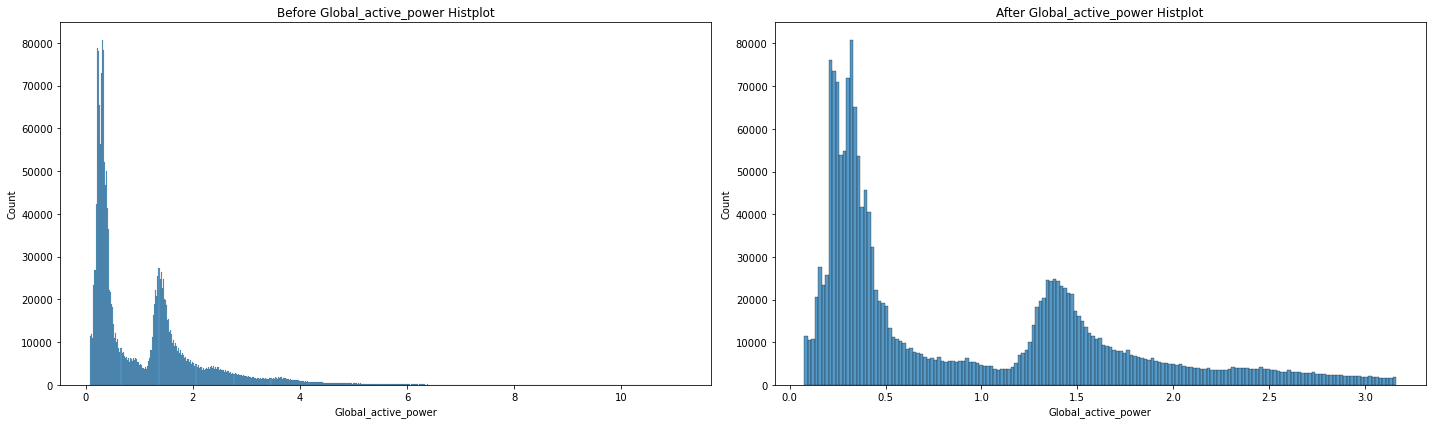

In [20]:
#Display Outliers on Histogram
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(x = "Global_active_power", data=electricity_df, ax=axs[0])
axs[0].set_title("Before Global_active_power Histplot")
sns.histplot(x = "Global_active_power", data=electricity_df_out, ax=axs[1])
axs[1].set_title("After Global_active_power Histplot")
fig.tight_layout()
plt.show()

In [21]:
print("The mean of Before Global_active_power: " + str(electricity_df["Global_active_power"].mean()))
print("The median of Before Global_active_power: " + str(electricity_df["Global_active_power"].median()))
print("The mean of After Global_active_power: " + str(electricity_df_out["Global_active_power"].mean()))
print("The median of After Global_active_power: " + str(electricity_df_out["Global_active_power"].median()))

The mean of Before Global_active_power: 1.091615036500693
The median of Before Global_active_power: 0.602
The mean of After Global_active_power: 0.9170230412226718
The median of After Global_active_power: 0.514


Even though I got rid of the outliers from the dataset to have a more accurate results on my further processes, the difference between mean and median results didn't change drastically. In the graph, it is visible that there is right skew, so I will fill the NaN values with median rather than mean values in the future cells.

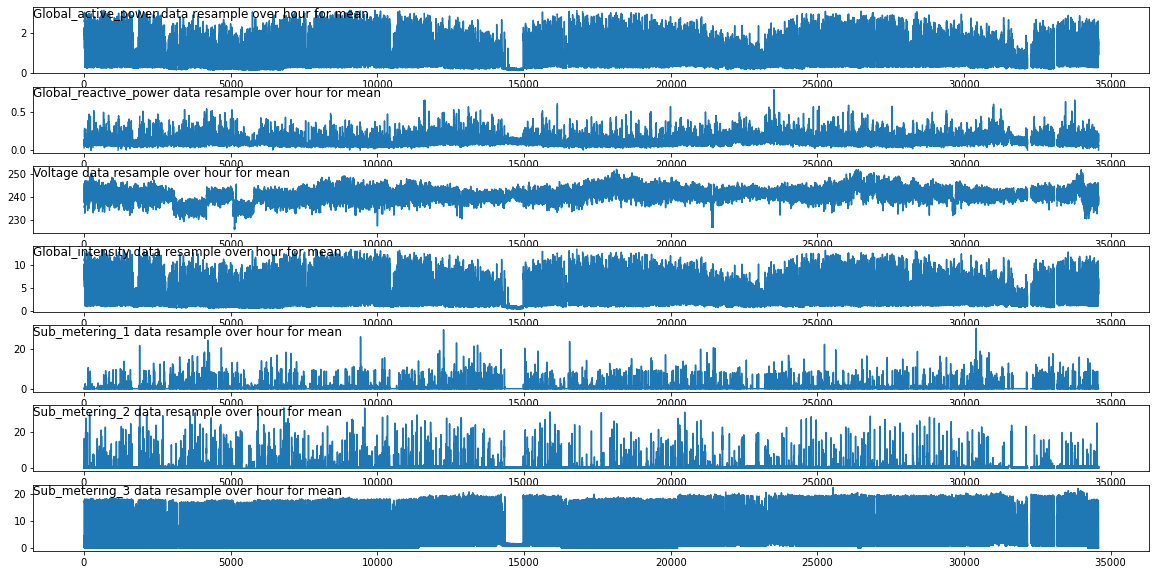

In [22]:
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(electricity_df_out.resample('H').mean().values[:, col])
    plt.title(electricity_df_out.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

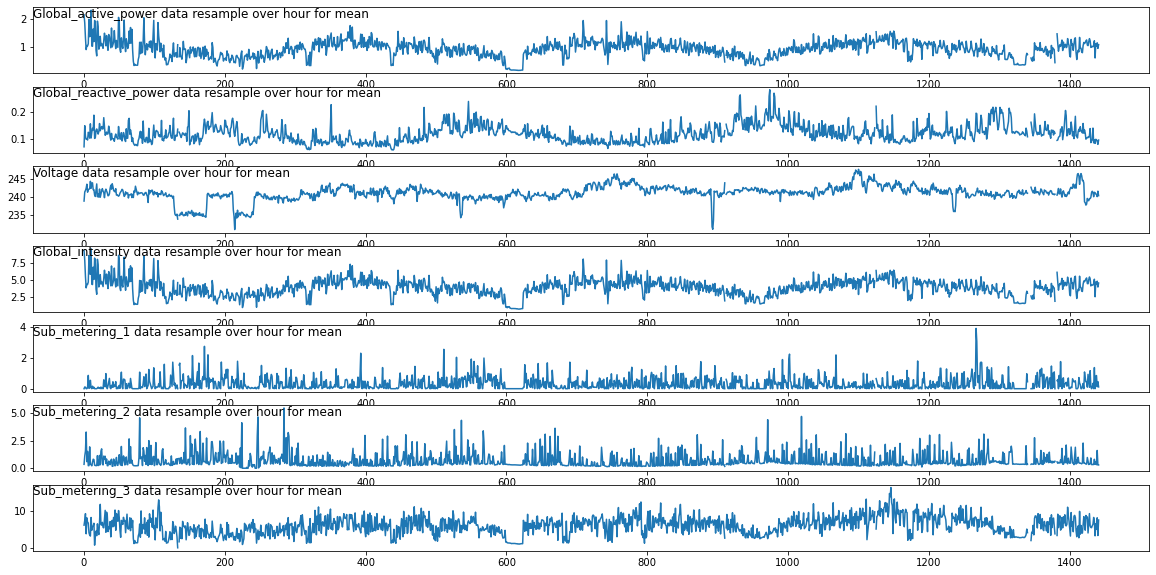

In [23]:
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(electricity_df_out.resample('D').mean().values[:, col])
    plt.title(electricity_df_out.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

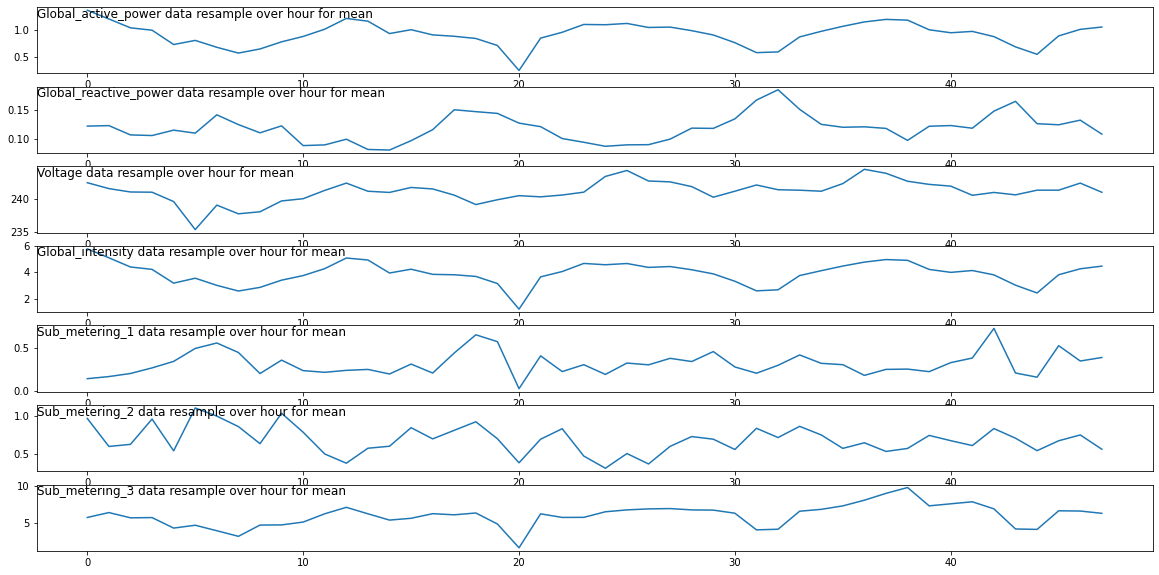

In [24]:
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(electricity_df_out.resample('M').mean().values[:, col])
    plt.title(electricity_df_out.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

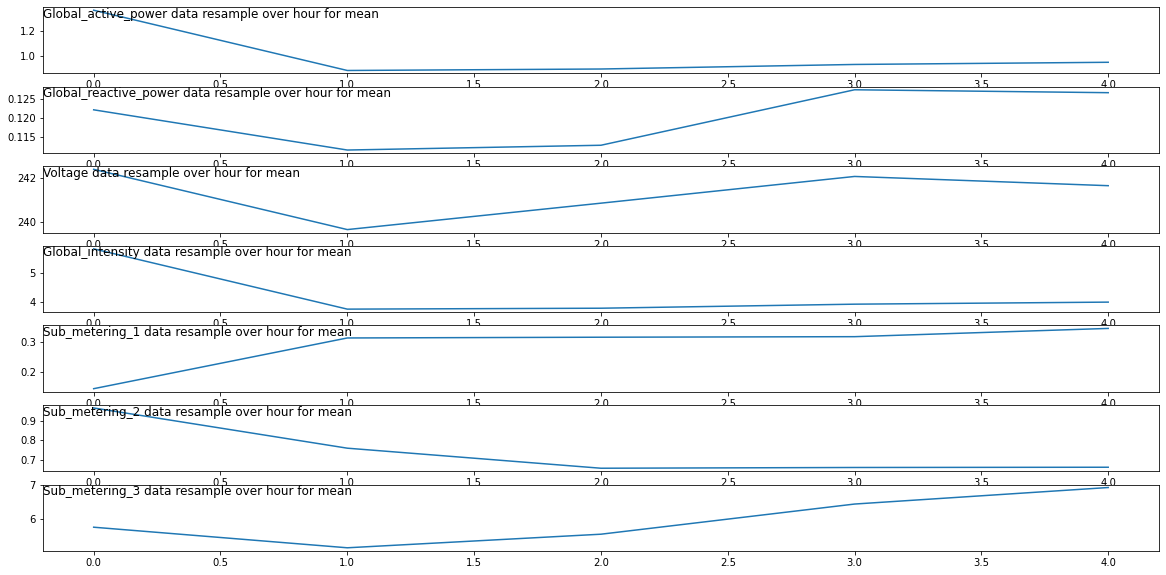

In [25]:
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(electricity_df_out.resample('Y').mean().values[:, col])
    plt.title(electricity_df_out.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.199294,-0.299190,0.998064,0.222292,0.222721,0.718929
Global_reactive_power,0.199294,1.000000,-0.074108,0.227637,0.057526,0.143166,0.060931
Voltage,-0.299190,-0.074108,1.000000,-0.313866,-0.069440,-0.071568,-0.230746
Global_intensity,0.998064,0.227637,-0.313866,1.000000,0.229684,0.231641,0.706431
Sub_metering_1,0.222292,0.057526,-0.069440,0.229684,1.000000,-0.002778,-0.022795
Sub_metering_2,0.222721,0.143166,-0.071568,0.231641,-0.002778,1.000000,-0.018291
Sub_metering_3,0.718929,0.060931,-0.230746,0.706431,-0.022795,-0.018291,1.000000


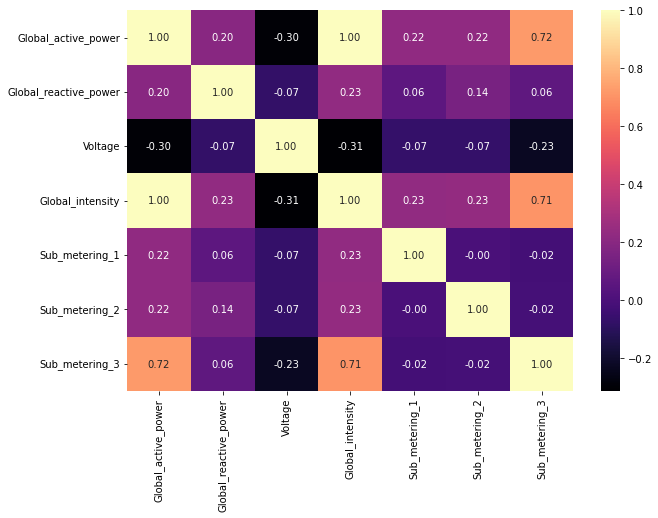

In [26]:
f, ax = plt.subplots(figsize= [10,7])
sns.heatmap(electricity_df_out.corr(), annot=True, fmt=".2f", ax=ax, cmap = "magma" )
correlation = electricity_df_out.corr()
correlation

### 3- Data Preprocessing

In [27]:
electricity_df_out

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:54:00,2.720,0.000,235.06,11.6,0.0,0.0,17.0
2006-12-16 17:59:00,2.472,0.058,236.94,10.4,0.0,0.0,17.0
2006-12-16 18:00:00,2.790,0.180,237.52,11.8,0.0,0.0,18.0
2006-12-16 18:01:00,2.624,0.144,238.20,11.0,0.0,0.0,17.0
2006-12-16 18:02:00,2.772,0.118,238.28,11.6,0.0,0.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [28]:
electricity_df_out.index.min(),electricity_df_out.index.max()

(Timestamp('2006-12-16 17:54:00'), Timestamp('2010-11-26 21:02:00'))

In [29]:
electricity_df_out[25:35]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 18:48:00,2.786,0.188,234.99,12.0,0.0,2.0,17.0
2006-12-16 18:49:00,2.540,0.088,234.67,10.8,0.0,4.0,17.0
2006-12-16 18:50:00,2.496,0.080,233.92,10.6,0.0,3.0,17.0
2006-12-16 18:51:00,2.336,0.070,233.51,10.0,0.0,1.0,16.0
2006-12-16 18:52:00,2.322,0.000,233.44,9.8,0.0,0.0,17.0
2006-12-16 18:53:00,2.448,0.000,233.64,10.6,0.0,1.0,17.0
2006-12-16 20:55:00,1.832,0.170,237.54,8.4,0.0,0.0,17.0
2006-12-16 20:56:00,2.044,0.102,237.44,9.4,0.0,0.0,18.0
2006-12-16 21:02:00,1.692,0.054,238.72,7.8,0.0,0.0,18.0


There are missing minutes between electricty_df_out and electricity_df because I dropped the outliers from the dataset. In order to form a better dataset, I will combine these and then replace the 0 values if not seen then interpolate the graph to have a better understanding.

In [30]:
temp_elec = electricity_df.copy()
for col in temp_elec.columns:
    temp_elec[col].values[:] = np.nan
temp_elec = temp_elec.add_suffix('_x')
temp_elec_cols = temp_elec.columns
temp_elec.head(10)

,Global_active_power_x,Global_reactive_power_x,Voltage_x,Global_intensity_x,Sub_metering_1_x,Sub_metering_2_x,Sub_metering_3_x
datetime,,,,,,,
2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
elec_join = temp_elec.join(electricity_df_out)
elec_join.isnull().sum()

Global_active_power_x      2075259
Global_reactive_power_x    2075259
Voltage_x                  2075259
Global_intensity_x         2075259
Sub_metering_1_x           2075259
Sub_metering_2_x           2075259
Sub_metering_3_x           2075259
Global_active_power         136473
Global_reactive_power       136473
Voltage                     136473
Global_intensity            136473
Sub_metering_1              136473
Sub_metering_2              136473
Sub_metering_3              136473
dtype: int64

In [32]:
elec_join.drop(temp_elec_cols, axis=1, inplace=True)
elec_join

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0


In [33]:
elec_join = elec_join.fillna(elec_join.interpolate())
elec_join = elec_join[36:]
elec_join = elec_join[:-2]

I did the elimination from the start and the end of the time series to have a compact dataset for my future evaluation based on hour.Also, the first 30 rows had NaN values and filling them with the bfill method could ruin the dataset and I didn't want to risk it.

In [34]:
electricity_df_hourly = elec_join.resample('H').sum()

In [35]:
electricity_df_hourly.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 18:00:00,162.481967,4.632262,14138.581311,696.521311,0.0,117.827869,1020.0
2006-12-16 19:00:00,135.822295,3.051639,14088.408197,596.508197,0.0,42.049180,1020.0
2006-12-16 20:00:00,118.191738,7.734098,14204.050492,534.170492,0.0,12.622951,1024.0
2006-12-16 21:00:00,130.083000,4.756600,14279.973000,586.480000,0.0,28.800000,1056.2
2006-12-16 22:00:00,121.820000,3.588400,14336.732000,533.820000,0.0,7.200000,262.3


In [36]:
electricity_df_hourly.loc[electricity_df_hourly['Global_active_power'] == 0,'Global_active_power'] = np.nan
electricity_df_hourly = electricity_df_hourly.fillna(electricity_df_hourly.interpolate())
electricity_df_hourly.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 18:00:00,162.481967,4.632262,14138.581311,696.521311,0.0,117.827869,1020.0
2006-12-16 19:00:00,135.822295,3.051639,14088.408197,596.508197,0.0,42.049180,1020.0
2006-12-16 20:00:00,118.191738,7.734098,14204.050492,534.170492,0.0,12.622951,1024.0
2006-12-16 21:00:00,130.083000,4.756600,14279.973000,586.480000,0.0,28.800000,1056.2
2006-12-16 22:00:00,121.820000,3.588400,14336.732000,533.820000,0.0,7.200000,262.3


In [37]:
electricity_df_hourly.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Instead of using mean or median to fill NaN values, I chosed to use interpolate method to have a nice transfer between hours, but there is a tiny problem in here. It doesnt just give the hourly global active power it gives the mean minute active power in one hour to us, but I want to have the hourly global active power. So, I will multiply it by 60 to have a more accurate information.

In [38]:
electricity_df_hourly.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 18:00:00,162.481967,4.632262,14138.581311,696.521311,0.0,117.827869,1020.0
2006-12-16 19:00:00,135.822295,3.051639,14088.408197,596.508197,0.0,42.049180,1020.0
2006-12-16 20:00:00,118.191738,7.734098,14204.050492,534.170492,0.0,12.622951,1024.0
2006-12-16 21:00:00,130.083000,4.756600,14279.973000,586.480000,0.0,28.800000,1056.2
2006-12-16 22:00:00,121.820000,3.588400,14336.732000,533.820000,0.0,7.200000,262.3


In [39]:
electricity_df_hourly.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34588.0,60.410584,43.960412,0.938,20.562,47.600,91.6945,188.612677
Global_reactive_power,34588.0,7.369500,3.988235,0.000,4.648,6.406,8.9280,47.022333
Voltage,34588.0,14454.897518,192.027493,239.820,14358.035,14461.830,14563.6850,15114.120000
Global_intensity,34588.0,256.528281,183.244187,3.800,91.000,203.200,384.4000,814.550000
Sub_metering_1,34588.0,29.393417,109.524234,0.000,0.000,0.000,0.0000,1803.666667
Sub_metering_2,34588.0,54.549511,162.796932,0.000,0.000,20.000,39.0000,2068.576923
Sub_metering_3,34588.0,382.891986,439.424185,0.000,39.000,99.000,830.0000,1471.470054


**Basic RNN:**

In [75]:
#Gathering only the target column
except_gap = electricity_df_hourly.drop(columns=["Global_active_power"])
gap = electricity_df_hourly["Global_active_power"]
print(except_gap.shape,gap.shape)

(34588, 6) (34588,)


If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

0.7428245631791862

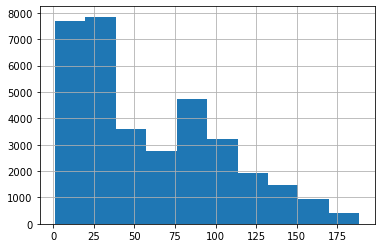

In [76]:
gap.hist()
gap.skew()

I first viewed the target column has any skewness or not. It had right skewness (positive skewed), so I will try to eliminate it by using sqrt and log, after that I will chose the better one. 

0.33178797533869003

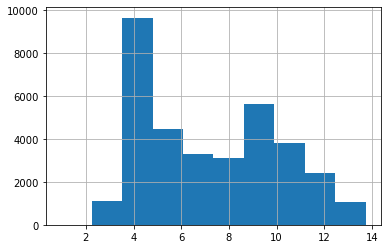

In [77]:
#1.Square Root Transform
np.sqrt(gap).hist()
temp_sqrt = np.sqrt(gap)
temp_sqrt.skew()

-0.05757109413179016

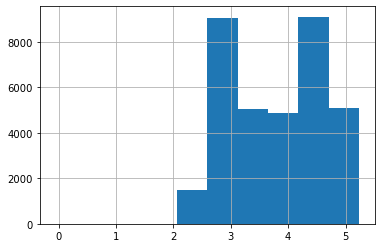

In [78]:
#2.Log Transform
np.log(gap).hist()
temp_log = np.log(gap)
temp_log.skew()

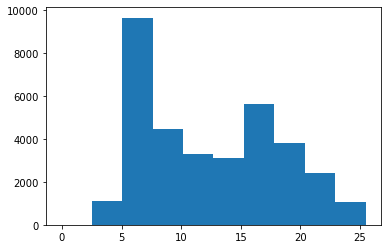

In [79]:
#3.Box-Cox Transform
plt.hist(stats.boxcox(gap,lmbda=0.5))
plt.show()

Between -0.5 and 0.5 is the optimal value for transforming if possible. At lmbda = 0, it was same as log transform, at 0.5, it was same as sqrt and at 1 it didn't transformed it at all. So, I will use the log transformation on the target column to have more accurate results. 

In [80]:
gap_log = np.log(gap)
print("gap_log minimum: "+str(gap_log.min()) + "\n"+"gap_log maximum: "+str(gap_log.max()))
gap_log.head(5)

gap_log minimum: -0.06400532997591243
gap_log maximum: 5.239695586841577


datetime
2006-12-16 18:00:00    5.090567
2006-12-16 19:00:00    4.911347
2006-12-16 20:00:00    4.772308
2006-12-16 21:00:00    4.868173
2006-12-16 22:00:00    4.802545
Freq: H, Name: Global_active_power, dtype: float64

<AxesSubplot:xlabel='datetime'>

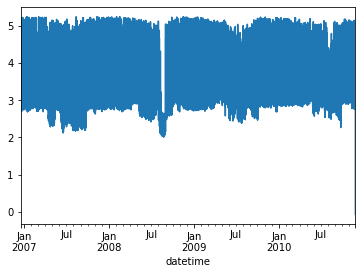

In [81]:
temp = gap_log
temp.plot()

1 2 3 4 5 - > 6        
2 3 4 5 6 - > 7       
3 4 5 6 7 - > 8        
...

In [82]:
def gap_split(df, window_size):
    gap_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(gap_np)-window_size):
        r = [[j] for j in gap_np[i:i+window_size]]
        X.append(r)
        l = gap_np[i+window_size]
        y.append(l)
    return np.array(X), np.array(y)

In [83]:
X, y = gap_split(temp, 5)
X.shape, y.shape

((34583, 5, 1), (34583,))

In [84]:
X_train, y_train = X[:30000], y[:30000]
X_val, y_val = X[30000:32250], y[30000:32250]
X_test, y_test = X[32250:], y[32250:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((30000, 5, 1), (30000,), (2250, 5, 1), (2250,), (2333, 5, 1), (2333,))

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences = False, input_shape = (5, 1)),
    keras.layers.Dense(8, activation = "relu"),
    keras.layers.Dense(1, activation = "linear")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_9 (Dense)             (None, 8)                 520       
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [86]:
es = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss = "mean_squared_error",
              optimizer = "Adam",
              metrics = ["RootMeanSquaredError"])

In [87]:
model_hist = model.fit(X_train, y_train,
                       epochs=10, batch_size = 32,
                       verbose = 1, callbacks=[es],
                       validation_data=(X_val, y_val))

Epoch 1/10


2022-08-28 20:36:42.124803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-28 20:36:42.230658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-28 20:36:42.295103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.5466 - root_mean_squared_error: 0.7393

2022-08-28 20:36:50.062894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-28 20:36:50.102121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


938/938 [==============================] - 10s 10ms/step - loss: 0.5466 - root_mean_squared_error: 0.7393 - val_loss: 0.2453 - val_root_mean_squared_error: 0.4953
Epoch 2/10
937/938 [============================>.] - ETA: 0s - loss: 0.2818 - root_mean_squared_error: 0.5309

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


938/938 [==============================] - 9s 10ms/step - loss: 0.2819 - root_mean_squared_error: 0.5309 - val_loss: 0.2414 - val_root_mean_squared_error: 0.4913
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285 - val_loss: 0.2442 - val_root_mean_squared_error: 0.4942
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2791 - root_mean_squared_error: 0.5283 - val_loss: 0.2552 - val_root_mean_squared_error: 0.5052
Epoch 5/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2794 - root_mean_squared_error: 0.5286 - val_loss: 0.2482 - val_root_mean_squared_error: 0.4982
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2791 - root_mean_squared_error: 0.5283 - val_loss: 0.2440 - val_root_mean_squared_error: 0.4940
Epoch 7/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2785 - root_mean_squared_error: 0.5278 - val_loss: 0.2571 - val_root_mean_

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


938/938 [==============================] - 9s 9ms/step - loss: 0.2783 - root_mean_squared_error: 0.5276 - val_loss: 0.2355 - val_root_mean_squared_error: 0.4852
Epoch 10/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2768 - root_mean_squared_error: 0.5261 - val_loss: 0.2385 - val_root_mean_squared_error: 0.4884


In [88]:
print('Training_set_results: {}'.format(model.evaluate(X_train, y_train)))
print('Validation_set_results: {}'.format(model.evaluate(X_val, y_val)))
print('Test_set_results: {}'.format(model.evaluate(X_test, y_test)))

938/938 [==============================] - 4s 4ms/step - loss: 0.2784 - root_mean_squared_error: 0.5276
Training_set_results: [0.2783961594104767, 0.5276325941085815]
71/71 [==============================] - 0s 4ms/step - loss: 0.2385 - root_mean_squared_error: 0.4884
Validation_set_results: [0.2385360300540924, 0.48840153217315674]
73/73 [==============================] - 0s 5ms/step - loss: 0.2608 - root_mean_squared_error: 0.5106
Test_set_results: [0.26075050234794617, 0.5106373429298401]


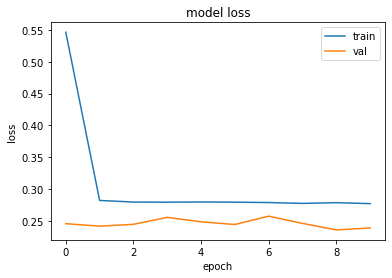

In [89]:
plt.plot(model_hist.history["loss"])
plt.plot(model_hist.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

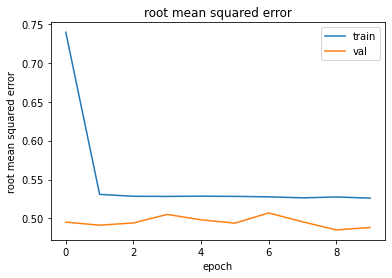

In [90]:
plt.plot(model_hist.history["root_mean_squared_error"])
plt.plot(model_hist.history["val_root_mean_squared_error"])
plt.title('root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [91]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

 37/938 [>.............................] - ETA: 2s

2022-08-28 20:38:09.719318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-28 20:38:09.757519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 0s 3ms/step


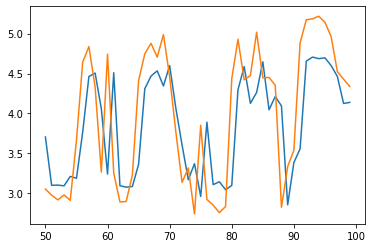

,Train Predictions,Actuals
0,4.385973,4.762712
1,4.379684,4.726928
2,4.355098,4.875495
3,4.487926,4.556358
4,4.181031,4.602487
5,4.301546,4.582955
6,4.260702,4.688831
7,4.364198,4.320869
8,4.031046,4.576791
9,4.326283,4.731221


In [92]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])
plt.show()
train_results.head(10)

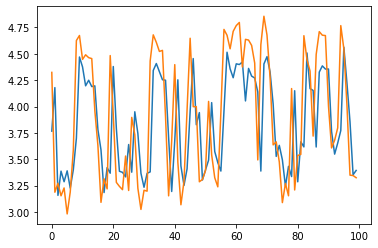

,Val Predictions,Actuals
0,3.766645,4.323285
1,4.179035,3.187674
2,3.157952,3.272303
3,3.387495,3.153847
4,3.287117,3.228192
5,3.390376,2.982140
6,3.227344,3.189406
7,3.399839,3.586847
8,3.699731,4.625188
9,4.469159,4.673090


In [93]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.show()
val_results.head(10)

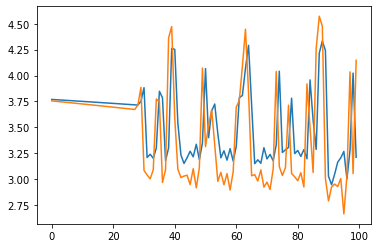

,Test Predictions,Actuals
0,3.769473,3.755409
1,3.767618,3.752468
2,3.765756,3.749519
3,3.763889,3.746561
4,3.762015,3.743594
5,3.760135,3.740618
6,3.758249,3.737634
7,3.756357,3.734641
8,3.754458,3.731638
9,3.752554,3.728627


In [94]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.show()
test_results.head(10)

**With Normalizing and using TimeSeriesGenerator:**

In [40]:
X_train1 = electricity_df_hourly[["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]][:30000].to_numpy()
X_val1 = electricity_df_hourly[["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]][30000:32250].to_numpy()
X_test1 = electricity_df_hourly[["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]][32250:].to_numpy()

y_train1 = electricity_df_hourly[["Global_active_power"]][:30000].to_numpy()
y_val1 = electricity_df_hourly[["Global_active_power"]][30000:32250].to_numpy()
y_test1 = electricity_df_hourly[["Global_active_power"]][32250:].to_numpy()

print(X_train1.shape, X_val1.shape, X_test1.shape)
print(y_train1.shape, y_val1.shape, y_test1.shape)

(30000, 7) (2250, 7) (2338, 7)
(30000, 1) (2250, 1) (2338, 1)


In [41]:
scaler_y = MinMaxScaler(feature_range = (0.05, 0.95))
y_train1 = scaler_y.fit_transform(y_train1)
y_val1 = scaler_y.transform(y_val1)
y_test1 = scaler_y.transform(y_test1)

scaler_X = MinMaxScaler(feature_range = (0.05, 0.95))
X_train1 = scaler_X.fit_transform(X_train1)
X_val1 = scaler_X.transform(X_val1)
X_test1 = scaler_X.transform(X_test1)

In [67]:
from keras.preprocessing.sequence import TimeseriesGenerator
window_size = 5
generator_train = TimeseriesGenerator(X_train1,
                                      y_train1,
                                      length = window_size,
                                      batch_size = 8)
generator_val = TimeseriesGenerator(X_val1,
                                     y_val1,
                                     length = window_size,
                                     batch_size = 1)
generator_test = TimeseriesGenerator(X_test1,
                                     y_test1,
                                     length = window_size,
                                     batch_size = 1)

In [68]:
rnn_model = keras.models.Sequential([
    keras.layers.LSTM(units = 256, input_shape = (window_size, X_train1.shape[1])),
    keras.layers.Dense(units = 128, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dense(units = 1)
])

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               270336    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 305,313
Trainable params: 305,313
Non-trainable params: 0
_________________________________________________________________


In [69]:
rnn_model.compile(loss = "mean_squared_error",
              optimizer = "Adam",
              metrics = ["RootMeanSquaredError"])

In [70]:
rnn_history = rnn_model.fit(generator_train,
                            steps_per_epoch = len(generator_train),
                            epochs = 10)

Epoch 1/10


2022-08-28 20:17:12.039153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-28 20:17:12.152290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-28 20:17:12.229807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 34s 9ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427
Epoch 2/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320
Epoch 3/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291
Epoch 4/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274
Epoch 5/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258
Epoch 6/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0156 - root_mean_squared_error: 0.1251
Epoch 7/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0154 - root_mean_squared_error: 0.1243
Epoch 8/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235
Epoch 9/10
3750/3750 [==============================] - 33s 9ms/ste

In [71]:
from sklearn.metrics import mean_squared_error

y_train_hat = rnn_model.predict(generator_train)
y_val_hat = rnn_model.predict(generator_val)
y_test_hat = rnn_model.predict(generator_test)

y_train_original = scaler_y.inverse_transform(y_train1)[:,0]
y_val_original = scaler_y.inverse_transform(y_val1)[:,0]
y_test_original = scaler_y.inverse_transform(y_test1)[:,0]
print(y_train_original)

y_train_hat_scaled = scaler_y.inverse_transform(y_train_hat)[:,0]
y_val_hat_scaled = scaler_y.inverse_transform(y_val_hat)[:,0]
y_test_hat_scaled = scaler_y.inverse_transform(y_test_hat)[:,0]
print(y_train_hat_scaled)

print(np.sqrt(mean_squared_error(y_train_original[window_size:], y_train_hat_scaled)))
print(np.sqrt(mean_squared_error(y_val_original[window_size:], y_val_hat_scaled)))
print(np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_scaled)))

  34/3750 [..............................] - ETA: 11s

2022-08-28 20:22:42.074128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-28 20:22:42.109917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2333/2333 [==============================] - 7s 3ms/step
[162.48196721 135.82229508 118.1917377  ...  56.612       23.952
  24.72      ]
[104.00538  104.8453   103.83615  ...  46.925827  43.862423  40.497643]
25.628770113642585
22.645559983901805
26.444705865370466


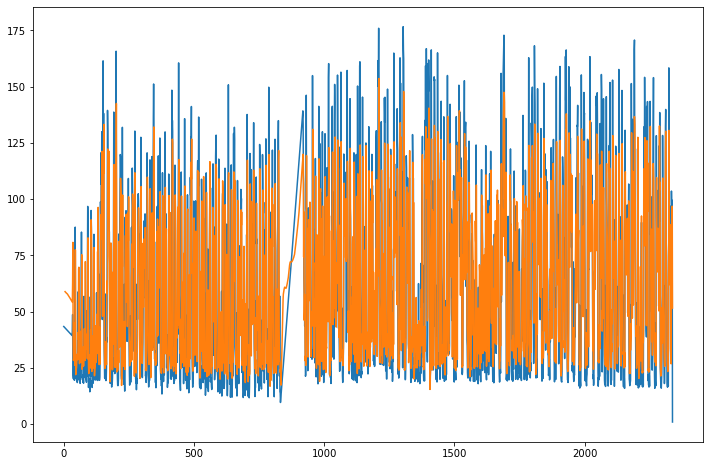

In [72]:
plt.figure(figsize = (12, 8))
plt.plot(range(len(y_test_original)), y_test_original)
plt.plot(np.arange(window_size, len(y_test_original)), y_test_hat_scaled)
plt.show()

In the first part, I only used the target column to estimate the future values whereas in the secon part, I used all columns to predict. The difference can be seen above but both of them successfully implemented.